# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```11_DA_annular_raw.ipynb```.

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

from essentials.physical_models import Annular
from essentials.bias_models import ESN
from essentials.Util import set_working_directories
rng = np.random.default_rng(0)

data_folder, results_folder = set_working_directories()


In [2]:
print(data_folder, results_folder)

/Users/andreanovoa/data/ /Users/andreanovoa/Library/CloudStorage/OneDrive-SharedLibraries-ImperialCollegeLondon/Magri, Luca - Novoa_CTRSP_2024/codes/PRIVATE_real-time-bias-aware-DA/tutorials/results/


## 1. Load data 
Create the reference truth and the observations.

The function ```create_truth``` is a compact form of the code below
```
  
# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, y_raw, t_true = [mat[key].squeeze() for key in ['y_filtered', 'y_raw', 't']]

t_max = 7.
i1 = np.argmin(abs(t_true - t_max))
y_true, y_raw, t_true = [xx[:i1] for xx in [y_true, y_raw, t_true]]
t_true -= t_true[0]

Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]
```


In [3]:
from essentials.create import create_truth
ER = 0.4875 + 0.025 * 2 # 0.4875 + np.arange(0, 4) * 0.025

t_start = Annular.t_transient
t_stop = t_start + Annular.t_CR * 15

truth = create_truth(model = data_folder + 'annular/ER_{}'.format(ER),
                     t_start = t_start,
                     t_stop = t_stop,
                     Nt_obs = 35,
                     t_max = t_stop + Annular.t_transient,
                     post_processed=False
                     )

results_folder += 'ER{}/'.format(ER)
os.makedirs(results_folder, exist_ok=True)


The output ```truth``` is a dictionary containing
```
dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t, 
     t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t, std_obs=std_obs)
```

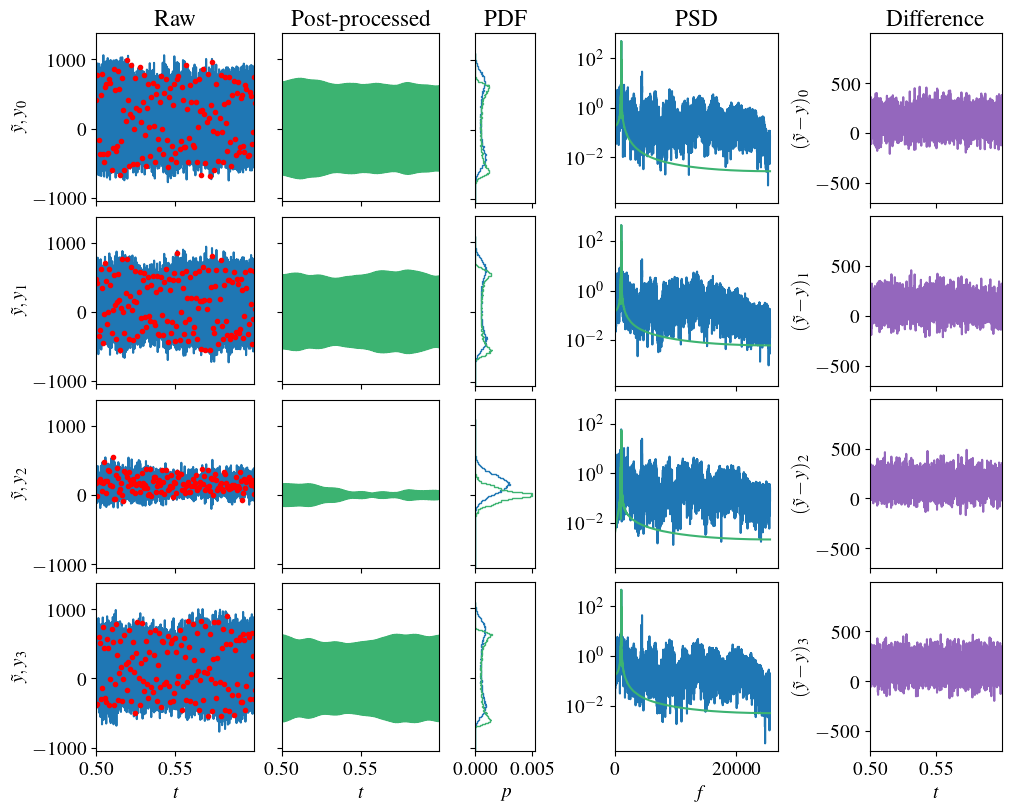

In [4]:
from essentials.plotResults import plot_truth
plot_truth(**truth, window=0.1)

## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The function ```create_ensemble``` consists of* 

```
alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = dict(m= 20, 
                     std_psi=0.3,
                     std_a=alpha0)

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)
ensemble.close()
```

In [5]:
from essentials.create import create_ensemble
alpha0 = dict(nu=(-15., 30.),
              c2beta=(10, 50),
              kappa=(1.E-4, 2.E-4),
              epsilon=(5e-3, 8e-3),
              omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.4, 0.6)
              )

forecast_params = dict(model=Annular, 
                       dt=truth['dt'], 
                       m=50, 
                       std_psi=0.3, 
                       std_a=alpha0
                       )

ensemble = create_ensemble(**forecast_params)

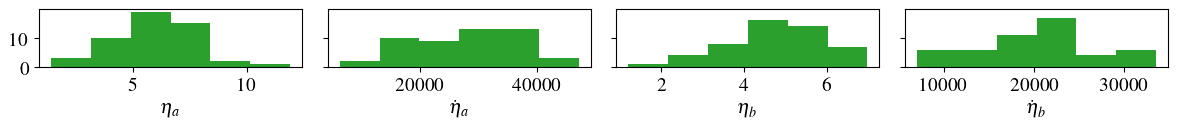

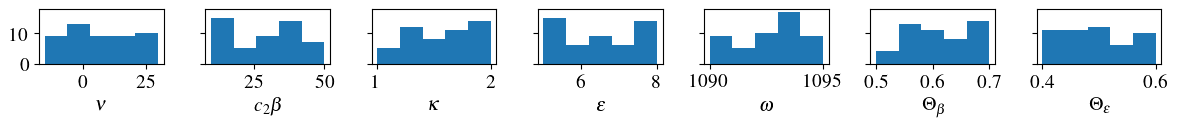

In [6]:
# Visualize ensemble initialization
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi, 'epsilon': 1e-3})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [7]:
from essentials.create import create_bias_training_dataset

ensemble_ESN = ensemble.copy()

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=10,
                    t_train=ensemble.t_transient / 3.,
                    t_test=ensemble.t_CR * 2,
                    t_val=ensemble.t_CR * 2,
                    # Training data generation options
                    augment_data=True,
                    biased_observations=True,
                    seed_W=0,
                    N_folds=4,
                    L=50,
                    std_a=alpha0,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-12, 1e-9]
                    )

ensemble_ESN.init_bias(**train_params)



**4.2 Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

```
from essentials.create import create_washout
wash_t, wash_obs = create_washout(ensemble.bias, t=t_true, y_raw=y_raw)
```

 Run multi-parameter training data: file train_data not found
Rerun training data

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-09	 -3.6516
2	 5.000e-01	 1.000e-03	 1.000e-09	 -3.5788
3	 5.000e-01	 1.000e-01	 1.000e-09	 -3.4736
4	 5.000e-01	 1.000e+01	 1.000e-12	 -2.8493
5	 6.667e-01	 1.000e-05	 1.000e-09	 -3.6273
6	 6.667e-01	 1.000e-03	 1.000e-09	 -3.5573
7	 6.667e-01	 1.000e-01	 1.000e-12	 -3.4406
8	 6.667e-01	 1.000e+01	 1.000e-12	 -2.9038
9	 8.333e-01	 1.000e-05	 1.000e-09	 -3.6226
10	 8.333e-01	 1.000e-03	 1.000e-09	 -3.5377
11	 8.333e-01	 1.000e-01	 1.000e-12	 -3.5148
12	 8.333e-01	 1.000e+01	 1.000e-12	 -2.9036
13	 1.000e+00	 1.000e-05	 1.000e-09	 -3.6207
14	 1.000e+00	 1.000e-03	 1.000e-12	 -3.5317
15	 1.000e+00	 1.000e-01	 1.000e-12	 -3.2500
16	 1.000e+00	 1.000e+01	 1.000e-12	 -3.0408
17	 5.320e-01	 6.166e-05	 1.000e-09	 -3.6210
18	 9.758e-01	 6.6

NameError: name 'save_ESN' is not defined

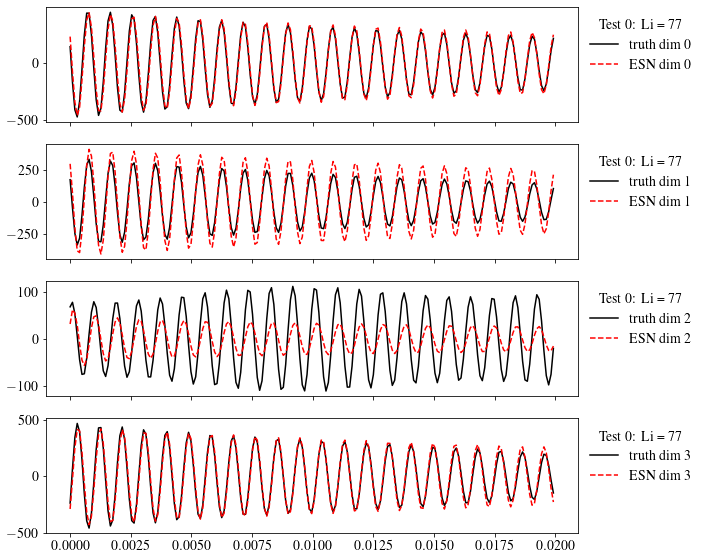

In [10]:
from essentials.Util import save_to_pickle_file, load_from_pickle_file

ESN_filename = results_folder + 'ESN_Case_transpose' 

if not os.path.isfile(ESN_filename):
    
    # train_data = np.load('train_data', allow_pickle=True)
    train_data = create_bias_training_dataset(truth['y_raw'],
                                              truth['y_true'], ensemble_ESN, **train_params)
    # 
    # np.save('train_data', train_data)
    
    
    ensemble_ESN.bias.train_bias_model(**train_data)
    
    ensemble_ESN.bias.t_init = truth['t_obs'][0] - 2 * truth['dt_obs']
    
    i1 = np.argmin(abs(ensemble_ESN.bias.t_init - truth['t']))
    i0 = i1 - ensemble_ESN.bias.N_wash  * ensemble_ESN.bias.upsample 
    
    wash_obs = truth['y_raw'][i0:i1 + 1:ensemble_ESN.bias.upsample]
    wash_t = truth['t'][i0:i1 + 1:ensemble_ESN.bias.upsample]
    
    if save_ESN:
        save_to_pickle_file(ESN_filename, ensemble_ESN.bias, wash_obs, wash_t)
else:
    bias, wash_obs, wash_t = load_from_pickle_file(ESN_filename)
    ensemble_ESN.bias = bias.copy()

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [ ]:
t_start = Annular.t_transient
t_stop = t_start + Annular.t_CR * 35


truth_og = create_truth(model = data_folder + 'annular/ER_{}'.format(ER),
                     t_start = t_start,
                     t_stop = t_stop,
                     Nt_obs = 30,
                     t_max = t_stop + Annular.t_transient,
                     post_processed=False
                     )

In [ ]:
rng = np.random.default_rng(6)

forecast_params['m'] = 20
forecast_params['std_a'] = dict(nu=(-10., 20.),
                                c2beta=(10, 50),
                                kappa=(1.E-4, 2.E-4),
                                epsilon=(5e-3, 8e-3),
                                omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
                                theta_b=(0.5, 0.7),
                                theta_e=(0.4, 0.6)
                                )

filter_ensemble = create_ensemble(**forecast_params)

In [ ]:
from essentials.DA import *
from essentials.Util import save_to_pickle_file

truth = truth_og.copy()
# save_to_pickle_file(results_dir + '', truth, out, bias, ensemble)

out = []
 # --------------
name = 'simulation_output_all'


ens_bb = filter_ensemble.copy()
ens_bb.t_init = truth['t_obs'][0]
ens_bb.inflation = 1.0
ens_bb.reject_inflation = 1.0

ens_ba = ens_bb.copy()
ens_ba.bias = ensemble_ESN.bias.copy()


DA_kwargs = dict(y_obs=truth['y_obs'].copy(), t_obs=truth['t_obs'].copy(), std_obs=0.1, 
                 wash_obs=wash_obs, wash_t=wash_t)

for kf in ['rBA_EnKF', 'EnKF']:
    
    if kf[0] == 'r':
        ks = np.linspace(0, 5, 6)
        blank_ens = ens_ba.copy()
    else:
        ks = [None]
        blank_ens = ens_bb.copy()

    blank_ens.filter = kf
    for kk in ks:
        ens = blank_ens.copy()
        
        if kf[0] == 'r':
            ens.regularization_factor = kk

        
        filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
        
        #Forecast the ensemble further without assimilation
        Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 10
        
        psi, t = filter_ens.time_integrate(Nt_extra)
        filter_ens.update_history(psi, t)
        
        y = filter_ens.get_observable_hist(Nt_extra)
        b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
        filter_ens.bias.update_history(b, t_b)
        
        filter_ens.close()
        
        out.append(filter_ens.copy())

save_to_pickle_file(results_folder + name, truth, out, ensemble_ESN.bias, ensemble)

In [ ]:
from essentials.plotResults import print_parameter_results
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf

truth_params = dict()
for param in filter_ens.params:
    if param == 'nu':
        truth_params[param] = Annular.nu_from_ER(ER)
    elif param == 'c2beta':
        truth_params[param] = Annular.c2beta_from_ER(ER)
    else:
        truth_params[param] = getattr(Annular, param)

print_parameter_results(out, true_values=truth_params)
               
truth['wash_t'] = wash_t
truth['wash_obs'] = wash_obs

windows = [(truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR * 1),
           (truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR * 5)]

for window, sub in zip(windows, ['short']):
    plot_states_PDF(out, truth, nbins=20, window=window)
    plt.savefig(results_folder + 'plot_states_PDF_' + sub + '.pdf')


plot_RMS_pdf(out, truth, nbins=20)
plt.savefig(results_folder + 'plot_RMS_pdf' + '.pdf')

In [ ]:
from essentials.plotResults import plot_timeseries, plot_parameters, plot_covariance#

for filter_ens in out:
    plot_timeseries(filter_ens, truth_og)
    plot_parameters(filter_ens, truth_og)
    plot_covariance(filter_ens)
    plt.show()